# Diabetic Retinnopathy | Machine Learning Project

### Libraries

In [1]:
import numpy as np
import pandas as pd
import random, os
import shutil
import kagglehub
import os
import shutil

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import lite
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy

import matplotlib.pyplot as plt
from matplotlib.image import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import pickle

import warnings
warnings.filterwarnings('ignore')

### Connecting with Kaggle

In [2]:
# Install Kaggle API
!pip install -q Kaggle
!apt-get update
!apt-get install tree -y

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,804 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,092 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,078 kB]
Hit:13 https://ppa.launchpadco

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Setting up Kaggle credentials
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Keys/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered --unzip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered
License(s): CC0-1.0
 91% 390M/427M [00:03<00:00, 97.6MB/s]
100% 427M/427M [00:04<00:00, 110MB/s] 


In [5]:
# List directory after unzipping
print("Top-level files and folders:")
print(os.listdir())

Top-level files and folders:
['.config', 'gaussian_filtered_images', 'train.csv', 'drive', 'sample_data']


### Loading the Data

In [7]:
# Loading the CSV file into a pandas DataFrame
path = "/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered"
df = pd.read_csv("/content/train.csv")

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
print(df.head())

# Image folder root
image_root = os.path.join(path, 'gaussian_filtered_images', 'gaussian_filtered_images')

# Output base folder
output_root = "/content/processed"

        id_code  diagnosis binary_type            type
0  000c1434d8d7          2          DR        Moderate
1  001639a390f0          4          DR  Proliferate_DR
2  0024cdab0c1e          1          DR            Mild
3  002c21358ce6          0       No_DR           No_DR
4  005b95c28852          0       No_DR           No_DR


### Creating Paths

In [8]:
# Reviewing the paths
path = "/content" # Corrected path
print("Downloaded path:", path)
print("Contents of the folder:")
print(os.listdir(path))

Downloaded path: /content
Contents of the folder:
['.config', 'gaussian_filtered_images', 'train.csv', 'drive', 'sample_data']


In [9]:
# Images
images = os.path.join(path, 'gaussian_filtered_images', 'gaussian_filtered_images')
print("Contents of the folder:", os.listdir(images))

Contents of the folder: ['Proliferate_DR', 'No_DR', 'Severe', 'Mild', 'export.pkl', 'Moderate']


In [11]:
# Loading the CSV
print(df.head(10))

        id_code  diagnosis binary_type            type
0  000c1434d8d7          2          DR        Moderate
1  001639a390f0          4          DR  Proliferate_DR
2  0024cdab0c1e          1          DR            Mild
3  002c21358ce6          0       No_DR           No_DR
4  005b95c28852          0       No_DR           No_DR
5  0083ee8054ee          4          DR  Proliferate_DR
6  0097f532ac9f          0       No_DR           No_DR
7  00a8624548a9          2          DR        Moderate
8  00b74780d31d          2          DR        Moderate
9  00cb6555d108          1          DR            Mild


### Viewing Data Distrubution

<Axes: xlabel='type'>

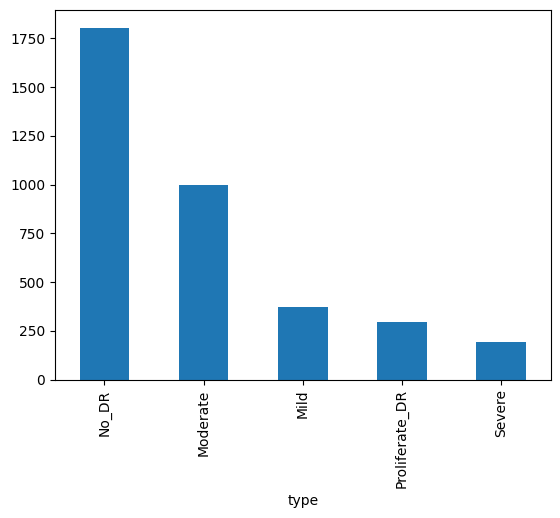

In [12]:
df['type'].value_counts().plot(kind='bar')

<Axes: xlabel='binary_type'>

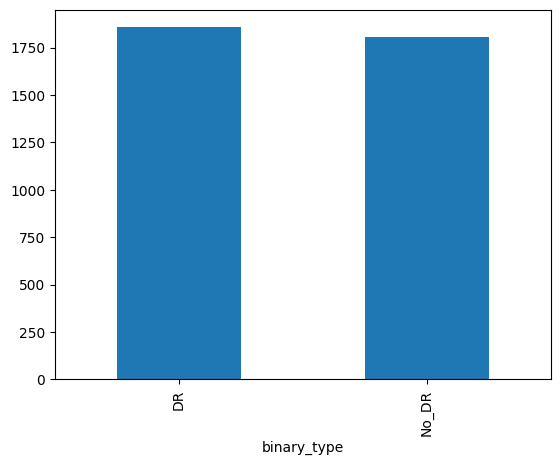

In [13]:
df['binary_type'].value_counts().plot(kind='bar')

### Split Data to Train, Test & Validation test

In [14]:
# Split into stratified train, val, and test sets
train_mid, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_mid, test_size = 0.15 / (1 - 0.15), stratify = train_mid['type'])

print("Train Set:")
print(train['type'].value_counts(), '\n')

print("Test Set:")
print(test['type'].value_counts(), '\n')

print("Val Set:")
print(val['type'].value_counts(), '\n')

Train Set:
type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

Test Set:
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

Val Set:
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [15]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [16]:
src_dir = "/content/gaussian_filtered_images/gaussian_filtered_images"
print(os.listdir(src_dir))

['Proliferate_DR', 'No_DR', 'Severe', 'Mild', 'export.pkl', 'Moderate']


### Setting up the Directory

In [17]:
# Setting up the source directory
src_dir = "/content/gaussian_filtered_images/gaussian_filtered_images"  # actual path in Colab

# Setting up destination working directories
base_dir = "/content/processed"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Recreateing destination folders
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.makedirs(train_dir)
os.makedirs(val_dir)
os.makedirs(test_dir)

# Defining a function to copy the data
def copy_split(df, split_dir):
    for _, row in df.iterrows():
        diagnosis = row['type']
        binary = row['binary_type']
        filename = row['id_code'] + ".png"

        srcfile = os.path.join(src_dir, diagnosis, filename)
        dst_folder = os.path.join(split_dir, binary)

        os.makedirs(dst_folder, exist_ok=True)

        if os.path.exists(srcfile):
            shutil.copy(srcfile, dst_folder)
        else:
            print(f"[Missing] {srcfile}")

# Copy all splits
copy_split(train, train_dir)
copy_split(val, val_dir)
copy_split(test, test_dir)

Viewing a Sample of the Train Set

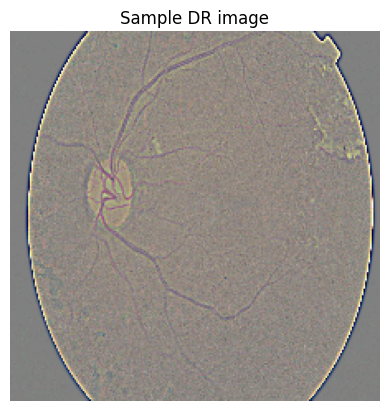

In [18]:
sample_folder = "/content/processed/train/DR"
sample_images = os.listdir(sample_folder)
img_path = os.path.join(sample_folder, random.choice(sample_images))

img = imread(img_path)
plt.imshow(img)
plt.title("Sample DR image")
plt.axis("off")
plt.show()

In [19]:
# Setting up ImageDataGenerator for train/val/test
train_path = '/content/processed/train'
val_path = '/content/processed/val'
test_path = '/content/processed/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Set up the training data generator using flow_from_directory
train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    train_path,
    target_size=img_size,
    class_mode='categorical', # Use 'categorical' for binary classification with 2 classes
    shuffle = True,
    batch_size=batch_size
)

# Setting up the validation data generator using flow_from_directory
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    val_path,
    target_size=img_size,
    class_mode='categorical',
    shuffle = True,
    batch_size=batch_size
)

# Seting up the test data generator using flow_from_directory
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    test_path,
    target_size=img_size,
    class_mode='categorical',
    shuffle = False,
    batch_size=batch_size
)

print("Data generators train_batches, val_batches, and test_batches are now defined.")

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Data generators train_batches, val_batches, and test_batches are now defined.


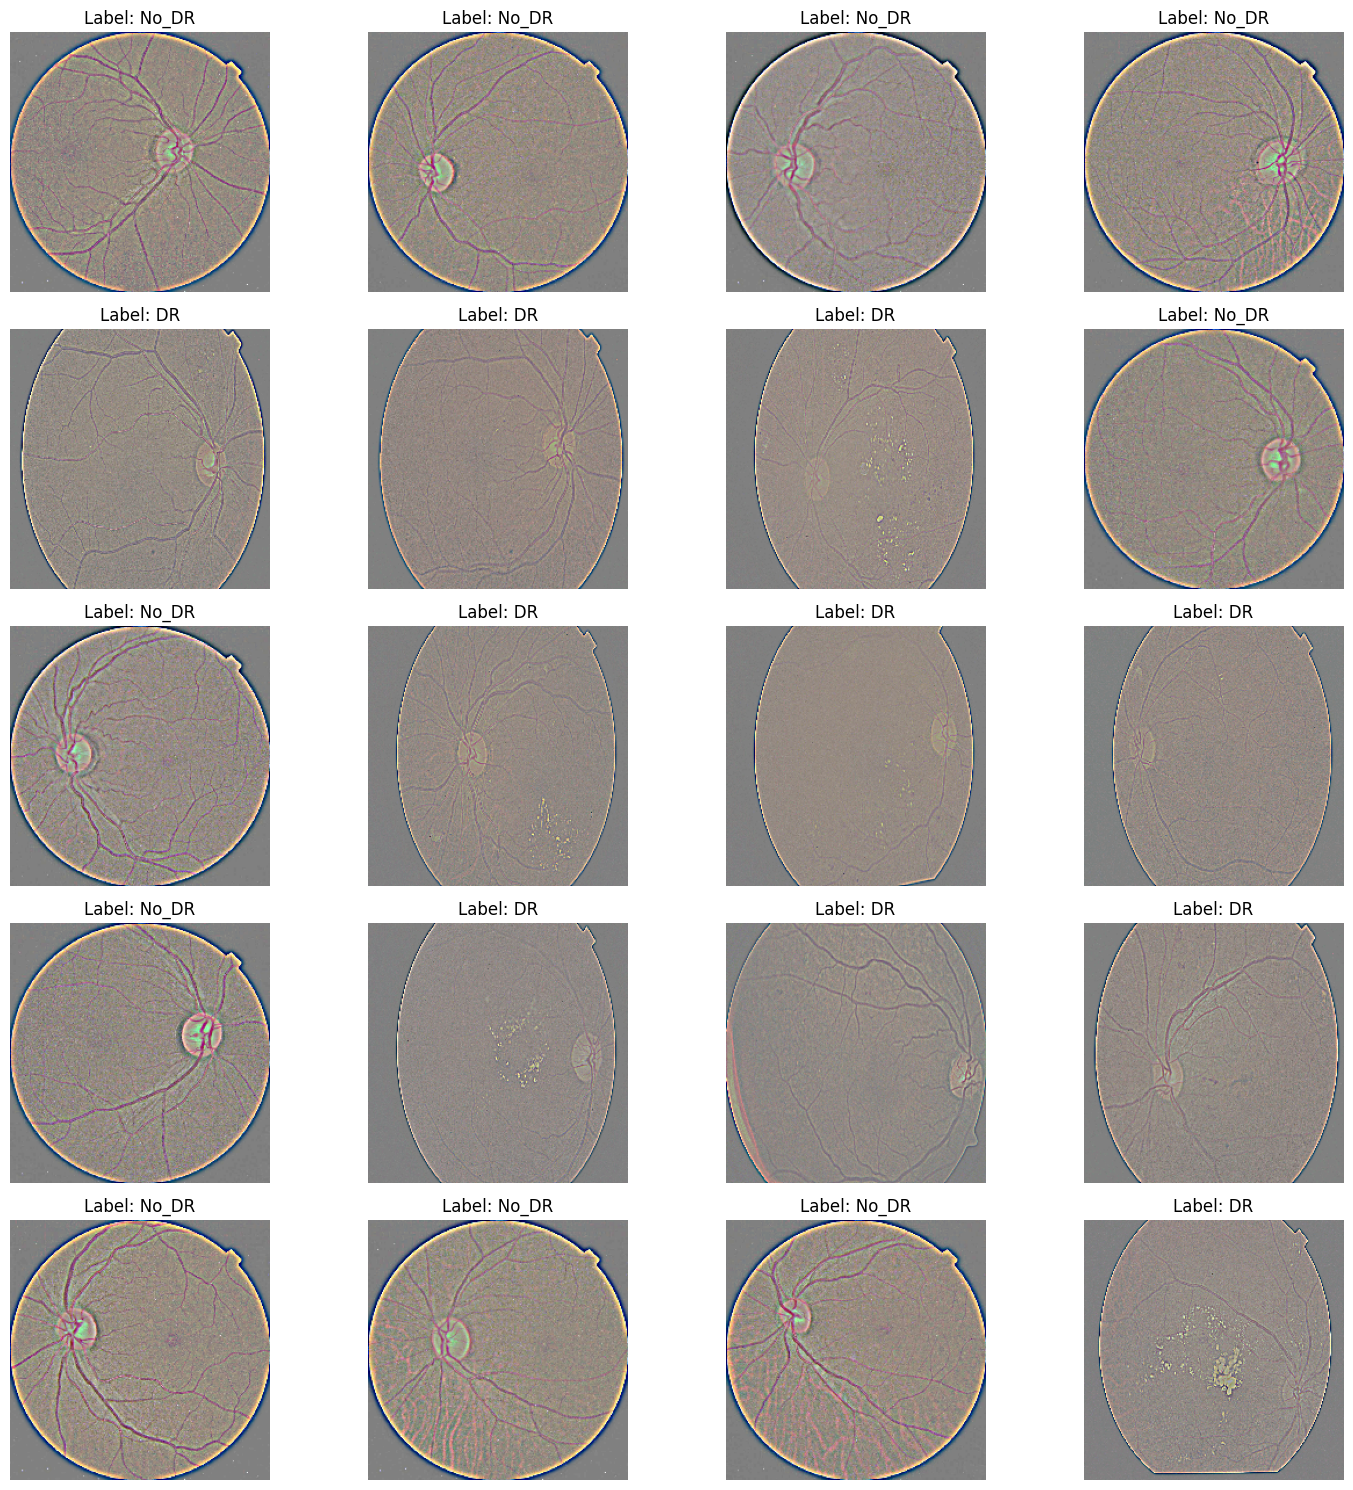

In [33]:
# Image Batching
images, labels = next(train_batches)

# Class names from the generator
class_names = list(train_batches.class_indices.keys())

# Ploting 20 images to review in the training set
num_images_to_show = min(20, len(images))
plt.figure(figsize=(15, 15))

for i in range(num_images_to_show):
    plt.subplot(5, 4, i + 1)
    plt.imshow(images[i])
    # Get the true label
    true_label_index = np.argmax(labels[i])
    true_label = class_names[true_label_index]
    plt.title(f"Label: {true_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Building the Model & Learn

In [20]:
# Building the model
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches, epochs=30, validation_data = val_batches)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 742ms/step - acc: 0.8151 - loss: 0.4779 - val_acc: 0.5182 - val_loss: 0.6677
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 54s 668ms/step - acc: 0.9051 - loss: 0.2622 - val_acc: 0.5182 - val_loss: 0.7266
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 681ms/step - acc: 0.9061 - loss: 0.2493 - val_acc: 0.5709 - val_loss: 0.7024
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 53s 652ms/step - acc: 0.9261 - loss: 0.1990 - val_acc: 0.6582 - val_loss: 0.5325
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 59s 731ms/step - acc: 0.9321 - loss: 0.1953 - val_acc: 0.8091 - val_loss: 0.3599
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 59s 734ms/step - acc: 0.9294 - loss: 0.1919 - val_acc: 0.8964 - val_loss: 0.2570
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 58s 713ms/step - acc: 0.9306 - loss: 0.1894 - val_acc: 0.9091 - val_loss: 0.2209
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 58s 715ms/step - acc: 0.9370 - loss: 0.1866 - val_acc: 0.9200 - val_loss: 0.2048
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 67s 829ms/

### Evaluating the Model

In [21]:
# Evaluate the model on the test set
print("Evaluating model on the test set:")
loss, acc = model.evaluate(test_batches, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

Evaluating model on the test set:
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - acc: 0.9324 - loss: 0.1906
Test Loss: 0.1704
Test Accuracy: 0.9455


### Creating Confusion Matrix



In [28]:
# Getting the true labels from the test_batches generator
test_batches.reset()
true_labels = test_batches.classes
class_names = list(test_batches.class_indices.keys())

# Get the model's predictions on the test data
predictions = model.predict(test_batches, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Classification report
report = classification_report(true_labels, predicted_classes, target_names=class_names)

print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(report)

Confusion Matrix:
[[261  18]
 [ 12 259]]

Classification Report:
              precision    recall  f1-score   support

          DR       0.96      0.94      0.95       279
       No_DR       0.94      0.96      0.95       271

    accuracy                           0.95       550
   macro avg       0.95      0.95      0.95       550
weighted avg       0.95      0.95      0.95       550



### Plotting the Confusion Matrix

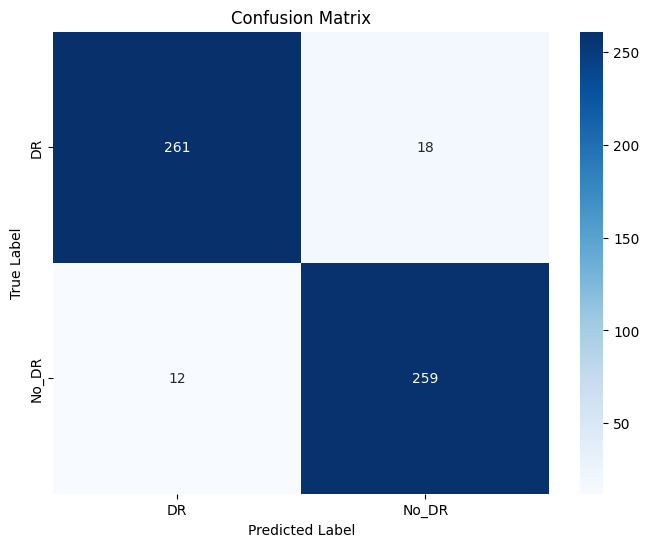

In [30]:
# Plotting the confusion Matrix for better overview

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Reasoning**:
The confusion matrix and classification report were not successfully defined in the previous attempt.



### Saving the Model
Saving the Model as Pickle

In [27]:
# Saving it as pickle
# Source path of the saved pickle file
source_path = '/content/CNN_model.pkl'

# Destination folder path in Google Drive
drive_folder_path = '/content/drive/MyDrive/trained_models'

# Creating the destination folder in Google Drive in case it doesn't exist
os.makedirs(drive_folder_path, exist_ok=True)

# Destination path for the pickle file in Google Drive
destination_path = os.path.join(drive_folder_path, 'CNN_model.pkl')

# Exporting pickle file to Google Drive
try:
    shutil.copy(source_path, destination_path)
    print(f"Model successfully copied to {destination_path}")
except FileNotFoundError:
    print(f"Error: Source file not found at {source_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Model successfully copied to /content/drive/MyDrive/trained_models/CNN_model.pkl
